<h2> IF867 - Introdução à Aprendizagem Profunda </h2>

<h3> Equipe: </h3>

*   Jeferson Severino
*   Luan Eustáquio
*   Matheus Lafayette



<h3> Definição do Problema e Objetivos </h3>

Este projeto visa desenvolver e comparar diferentes arquiteturas de redes neurais profundas para a classificação de imagens de raio-X em fraturadas e não fraturadas. Utilizamos modelos pré-treinados como VGG19, ResNet18 e ConvNext, aplicando diversas técnicas de ajuste e otimização. Além disso, implementamos um ensemble de modelos para melhorar a precisão da classificação. O objetivo é avaliar o desempenho de cada modelo e explorar como técnicas avançadas de deep learning podem ser aplicadas na área médica.

## Dataset

In [ ]:
import numpy as np
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights, resnet18, ResNet18_Weights, convnext_base, ConvNeXt_Base_Weights, vgg16
from torchvision.transforms.functional import InterpolationMode

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tqdm.auto import tqdm
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#from google.colab import drive
#drive.mount('/content/drive')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_data = ImageFolder("data/train")
val_data = ImageFolder("data/val")
test_data = ImageFolder("data/test")

In [ ]:
len(train_data), len(val_data), len(test_data)

(9246, 829, 506)

In [ ]:
total_len_data = len(train_data) + len(val_data) + len(test_data)
len(train_data) / total_len_data, len(val_data) / total_len_data, len(test_data) / total_len_data

(0.8738304508080522, 0.07834798223230319, 0.047821566959644644)

## Dataset Visualization

<p align="justify">
Este conjunto de dados consiste em imagens de raios-X fraturadas e não fraturadas que abrangem todas as regiões anatômicas do corpo, incluindo membros inferiores, membros superiores, lombar, quadris, joelhos, etc. O conjunto de dados está categorizado em pastas de treino, teste e validação, cada uma contendo imagens radiográficas fraturadas e não fraturadas.

<p align="justify">
Este conjunto de dados contém 10.580 imagens radiográficas (raios-X).

Dados de Treinamento
Número de Imagens: 9.246

Dados de Validação
Número de Imagens: 828

Dados de Teste
Número de Imagens: 506

<p align="justify">

Amostras aleatórias do conjunto dos conjuntos de dados de treinamento. As amostras contém as duas classes o raio x com fratura e o raio x sem fratura.

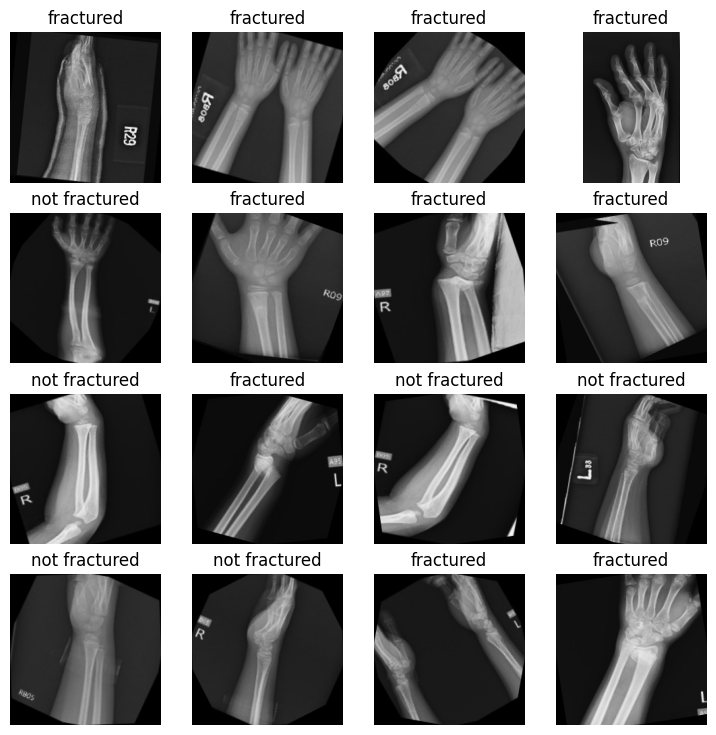

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(train_data.classes[label])
    plt.axis(False)

## Utils

<p align="justify">
Nessa seção estão contidas diversas funções auxiliares que serão utilizadas para o treinamento dos modelos, testes dos modelos e plotagem de gráficos.

<p align="justify">
Abaixo temos a função para treinamento do modelo. A função faz o treinamento do modelo pela quantidade de épocas que é passada como parâmetro. Para cada época, percorremos todo o os batches do conjunto de treino, calculamos a função de loss e atualizamos os pesos da rede. Em seguida, para cada época, o modelo tenta classificar os dados do conjunto de validação.

In [ ]:
def train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, device):
    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []

    for epoch in range(1, num_epochs + 1):
        train_loss = 0
        for (X, label) in tqdm(train_loader):
            X, label = X.to(device), label.to(device)

            model.train()
            y_pred = model(X)
            loss = loss_fn(y_pred, label)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_loss_hist.append(train_loss)

        val_acc = 0
        val_loss = 0

        model.eval()
        with torch.inference_mode():
            for (X, labels) in tqdm(val_loader):
                X, labels = X.to(device), labels.to(device)

                y_val_pred = model(X)
                val_loss += loss_fn(y_val_pred, labels).item()
                val_acc += accuracy_score(labels.cpu(), torch.argmax(y_val_pred, dim=1).cpu())

            val_loss /= len(val_loader)
            val_loss_hist.append(val_loss)
            val_acc /= len(val_loader)
            val_acc_hist.append(val_acc)

        print(f"train_loss : {train_loss} , val_acc : {val_acc} , val_loss : {val_loss} ")

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(train_loss_hist, label='Train loss')
    ax.plot(val_loss_hist, label='Validation loss:')
    ax.set_title("Loss value during training")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (CrossEntropy)')
    ax.legend()

<p align="justify">

A função abaixo serve para obter a loss e a acurácia do modelo para o conjunto de teste do dataset.

In [ ]:
def test(model, test_loader, loss_fn, device):
    model.eval()
    loss_test, accuracy_test = 0, 0

    with torch.inference_mode():
        for (X, label) in tqdm(test_loader):
            X, label = X.to(device), label.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, label)
            loss_test += loss.item()

            pred_label = y_pred.argmax(dim=1)
            accuracy_test += ((pred_label == label).sum().item()/len(pred_label))

    loss_test /= len(test_loader)
    accuracy_test /= len(test_loader)

    return loss_test, accuracy_test

<p align="justify">

Retorna todas as inferências do modelo para o conjunto de teste, junto com os targets.

In [ ]:
def model_infer(model, test_dataloader, device):
    predicted = []
    targets = []

    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            pred_label = y_pred.argmax(dim=1)
            predicted.extend(pred_label.cpu().numpy())
            targets.extend(y.cpu().numpy())

    return predicted, targets

<p align="justify">

Plot da matriz de confusão do modelo. A matriz de confusão indica ...

In [ ]:
def plot_confusion_matrix(targets, predicted):
    print("Confusion Matrix:")
    cm = confusion_matrix(targets, predicted)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [ ]:
def plot_classification_report(targets, predicted):
    print("\nClassification Report: \n", classification_report(targets, predicted))

<p align="justify">
Retorna o número de parâmetros totais e treináveis dos modelos. A informação sobre as quantidades de parâmetros serão utilizadas para comparar a complexidade entre diferentes modelos.

In [ ]:
def total_and_trainable_params(model):
    model_total_params = sum(p.numel() for p in model.parameters())
    model_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model_total_params, model_trainable_params

<p align="justify">
Dicionário que salva informações que serão utilizadas como métricas de comparação entre os modelos.

In [ ]:
history = {
    'VGG' : { 'train_time': 0, 'infer_time': 0, 'total_params': 0, 'trainable_params': 0, 'acc': 0, 'loss': 0 },
    'ResNet' : { 'train_time': 0, 'infer_time': 0, 'total_params': 0, 'trainable_params': 0, 'acc': 0, 'loss': 0 },
    'ConvNext': { 'train_time': 0, 'infer_time': 0, 'total_params': 0, 'trainable_params': 0, 'acc': 0, 'loss': 0 },
    'Ensemble': { 'infer_time': 0, 'acc': 0 },
    'ResNetSE': { 'train_time': 0, 'infer_time': 0, 'total_params': 0, 'trainable_params': 0, 'acc': 0, 'loss': 0 },
    'VGG_CBAM' : { 'train_time': 0, 'infer_time': 0, 'total_params': 0, 'trainable_params': 0, 'acc': 0, 'loss': 0 }
}

## Custom Dataset


<p align="justify">

Definição da classe que vai lidar com o dataset. Essa classe receberá os dados e as transformações que serão feitas. A classe também define métodos para retornar o tamanho dos datasets e aplicar as transformações definidas nos conjuntos de dados.

In [ ]:
class BoneFractureDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

<p align="justify">
O código abaixo define as transformações que serão feitas nos dados.

Essas transformações serão feitas para que os dados possam ser utilizados pelas redes pré-treinadas e para conversão da base de dados em tensores.

In [ ]:
## TALVEZ MUDAR TRANSFORMAÇÔES
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<p align="justified">
Definindo os datasets a partir dos dados lidos

In [ ]:
train_dataset = BoneFractureDataset(train_data, train_transforms)
val_dataset = BoneFractureDataset(val_data, data_transforms)
test_dataset = BoneFractureDataset(test_data, data_transforms)

<p align="justified">

Definindo os dataloaders. Vamos iterar pelos dataloaders, que estão divididos em batchs, para fazer o treinamento, validação e teste do nosso modelo.

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## VGG 19

<p align="justify">
Utilização do modelo pré-treinado da VGG 19. A rede VGG tem por característica principal a utilização dos blocos VGG, cada bloco VGG contém múltiplas convoluções consecutivas seguidas de uma operação de max pooling no final de cada bloco. No fim da rede existem camadas fully connected responsáveis por fazer a classificação no nosso caso.

A vgg-19 contém 19 camadas no total, somando os blocos e as camadas fully connected no fim da rede.

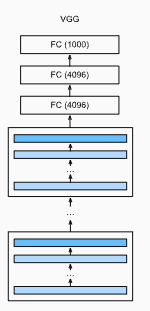

<p align="justify">
Criação da classe da VGG. Nessa classe estamos instanciando o modelo pré treinado da VGG e definindo os pesos com sendo os padrões (Treinandos na imagenet).

Além disso, estamos congelando a maioria dos pesos da rede para preservar o conhecimento pré adquirido pelo treinamento e tempo diminuir o tempo de treinamento para o novo dataset.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()
        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT)
        self.vgg.classifier[-1] = nn.Linear(4096, num_classes)

        for param in self.vgg.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.vgg(x)

    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), dim=1)

In [ ]:
num_classes = 2
epochs = 10
learning_rate = 0.0001

vgg = VGG19(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:44<00:00, 5.48MB/s] 


<p align="justify">

Obtendo a quantidade total de parâmetros do modelo e a quantidade total de parâmetros treináveis do modelo.

In [ ]:
vgg_total_params, vgg_trainable_params = total_and_trainable_params(vgg)
history['VGG']['total_params'] = vgg_total_params
history['VGG']['trainable_params'] = vgg_trainable_params

print(vgg_total_params, vgg_trainable_params)

139578434 119554050


<p align="justify">
Verificar os warnins abaixo: https://discuss.pytorch.org/t/handling-images-with-transparencies/7045/2

 46%|████▌     | 12/26 [00:04<00:04,  2.93it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.68it/s]


train_loss : 0.1084337903610749 , val_acc : 0.9831730769230769 , val_loss : 0.04686045355069487 


 12%|█▏        | 3/26 [00:01<00:09,  2.33it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


train_loss : 0.020234787055537662 , val_acc : 0.9927884615384616 , val_loss : 0.017169135813604113 


 15%|█▌        | 4/26 [00:01<00:07,  3.09it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.71it/s]


train_loss : 0.011664525565855916 , val_acc : 0.9903846153846154 , val_loss : 0.040079804185412425 


 15%|█▌        | 4/26 [00:01<00:08,  2.47it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


train_loss : 0.026895636248584247 , val_acc : 0.9963942307692307 , val_loss : 0.009676521732147263 


 50%|█████     | 13/26 [00:05<00:04,  3.13it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.66it/s]


train_loss : 0.03148431457814215 , val_acc : 0.9915865384615384 , val_loss : 0.026433742768998715 


 50%|█████     | 13/26 [00:05<00:04,  2.71it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.70it/s]


train_loss : 0.011524823613096154 , val_acc : 0.9829244031830238 , val_loss : 0.10997450381446328 


 96%|█████████▌| 25/26 [00:09<00:00,  2.67it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


train_loss : 0.009078045750359913 , val_acc : 0.9903846153846154 , val_loss : 0.05580122960645239 


 46%|████▌     | 12/26 [00:04<00:05,  2.59it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.73it/s]


train_loss : 0.011589697183639511 , val_acc : 0.9951923076923077 , val_loss : 0.029645201221362195 


 23%|██▎       | 6/26 [00:02<00:07,  2.77it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.74it/s]


train_loss : 0.018734641465736557 , val_acc : 0.9939903846153846 , val_loss : 0.01885932662281016 


 31%|███       | 8/26 [00:03<00:07,  2.32it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.74it/s]

train_loss : 0.04586832982535465 , val_acc : 0.9963942307692307 , val_loss : 0.019017347167551914 


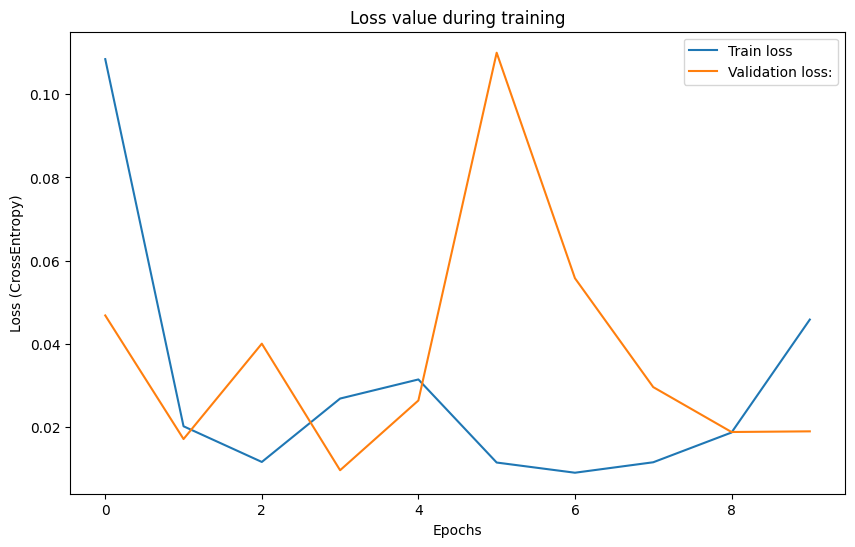

In [ ]:
time_before_train = time.time()
train(vgg, train_loader, val_loader, optimizer, loss_fn, epochs, device)
history['VGG']['train_time'] = time.time() - time_before_train

In [ ]:
time_before_inference = time.time()
loss_test, acc_test = test(vgg, test_loader, loss_fn, device)
history['VGG']['infer_time'] = time.time() - time_before_inference
history['VGG']['loss'] = loss_test
history['VGG']['acc'] = acc_test

100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

Confusion Matrix:


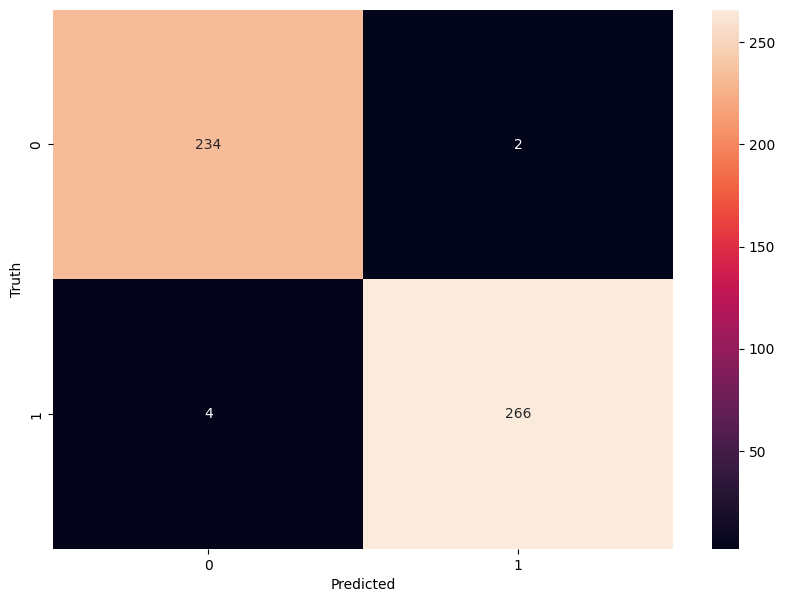

In [ ]:
target_vgg, predicted_vgg = model_infer(vgg, test_loader, device)

plot_confusion_matrix(target_vgg, predicted_vgg)

In [ ]:
plot_classification_report(target_vgg, predicted_vgg)


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       236
           1       0.99      0.99      0.99       270

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



## Resnet 18

<p align="justify">
Utilização do modelo pré-treinado da resnet 18.

Utilização do modelo pré-treinado da ResNet18. A rede ResNet (Residual Network) é conhecida por sua utilização dos blocos residuais, que ajudam a mitigar o problema do desaparecimento do gradiente em redes profundas. Cada bloco residual contém uma conexão de atalho que permite que a informação flua diretamente através da rede, facilitando o treinamento de redes muito profundas. Além disso, a ResNet utiliza camadas de Batch Normalization, que ajudam a estabilizar e acelerar o processo de treinamento.

A ResNet18 contém 18 camadas no total, incluindo convoluções, Batch Normalization, e camadas fully connected no fim da rede, responsáveis pela classificação no nosso caso.

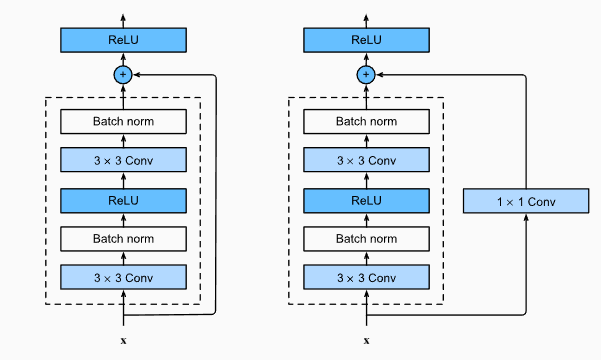

Criação da classe da ResNet18. Nessa classe estamos instanciando o modelo pré-treinado da ResNet18 e definindo os pesos como sendo os padrões (treinados na ImageNet).

Além disso, estamos congelando a maioria dos pesos da rede para preservar o conhecimento pré-adquirido pelo treinamento e diminuir o tempo de treinamento para o novo dataset.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet18.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        for name, param in self.resnet18.named_parameters():
            if "fc" not in name:
                param.requires_grad = False

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        return self.resnet18(x)

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
resnet = ResNet18(num_classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)

<p align="justify">

Obtendo a quantidade total de parâmetros do modelo e a quantidade total de parâmetros treináveis do modelo.

In [ ]:
resnet_total_params , resnet_trainable_params = total_and_trainable_params(resnet)
history['ResNet']['total_params'] = resnet_total_params
history['ResNet']['trainable_params'] = resnet_trainable_params
print(resnet_total_params, resnet_trainable_params)

11177538 1026


 73%|███████▎  | 19/26 [00:03<00:01,  4.90it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.45it/s]


train_loss : 0.642462523132047 , val_acc : 0.7244694960212201 , val_loss : 0.5788473911010302 


 92%|█████████▏| 24/26 [00:04<00:00,  6.35it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.38it/s]


train_loss : 0.5264480626500602 , val_acc : 0.8081482095490716 , val_loss : 0.49244584143161774 


 23%|██▎       | 6/26 [00:01<00:03,  5.11it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.33it/s]


train_loss : 0.4688581819146562 , val_acc : 0.8345905172413792 , val_loss : 0.44117917349705327 


 35%|███▍      | 9/26 [00:01<00:03,  4.57it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:05<00:00,  5.09it/s]


train_loss : 0.43021223928689134 , val_acc : 0.845905172413793 , val_loss : 0.41016338765621185 


 58%|█████▊    | 15/26 [00:02<00:02,  5.42it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.31it/s]


train_loss : 0.4067134773648734 , val_acc : 0.8420507294429709 , val_loss : 0.39442043464917403 


 12%|█▏        | 3/26 [00:00<00:06,  3.37it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.33it/s]


train_loss : 0.3846345806307446 , val_acc : 0.8357924403183024 , val_loss : 0.3828786840805641 


 65%|██████▌   | 17/26 [00:03<00:01,  4.98it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.39it/s]


train_loss : 0.3704425640997177 , val_acc : 0.8635610079575596 , val_loss : 0.36481547126403224 


 31%|███       | 8/26 [00:01<00:03,  5.63it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.41it/s]


train_loss : 0.3548710893800927 , val_acc : 0.8660891909814323 , val_loss : 0.3584833305615645 


 50%|█████     | 13/26 [00:02<00:02,  5.55it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


train_loss : 0.33963716545731965 , val_acc : 0.8686173740053051 , val_loss : 0.3463127257732245 


 31%|███       | 8/26 [00:01<00:02,  6.71it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.40it/s]

train_loss : 0.3350268777163383 , val_acc : 0.8597065649867374 , val_loss : 0.34260624188643235 


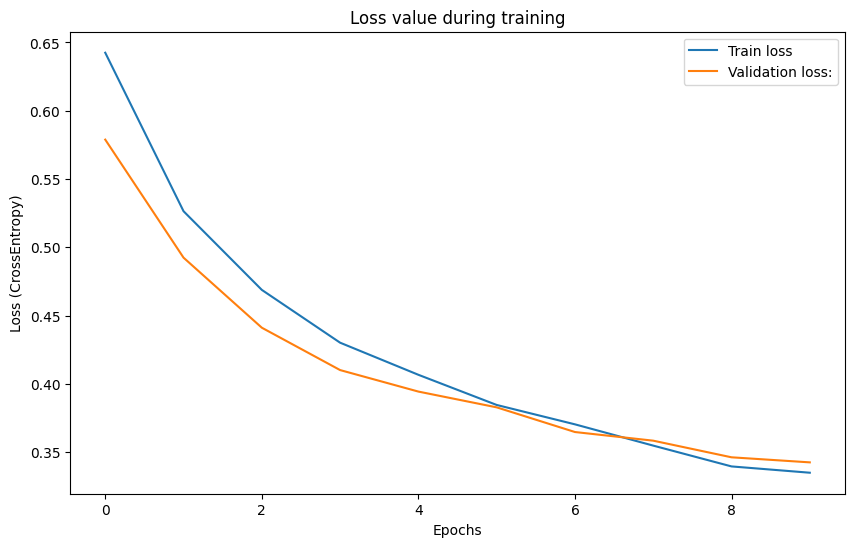

In [ ]:
time_before_train = time.time()
train(resnet, train_loader, val_loader, optimizer, loss_fn, epochs, device)
history['ResNet']['train_time'] = time.time() - time_before_train

In [ ]:
time_before_inference = time.time()
loss_test, acc_test = test(resnet, test_loader, loss_fn, device)
history['ResNet']['infer_time'] = time.time() - time_before_inference
history['ResNet']['loss'] = loss_test
history['ResNet']['acc'] = acc_test

100%|██████████| 16/16 [00:03<00:00,  4.80it/s]


100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

Confusion Matrix:


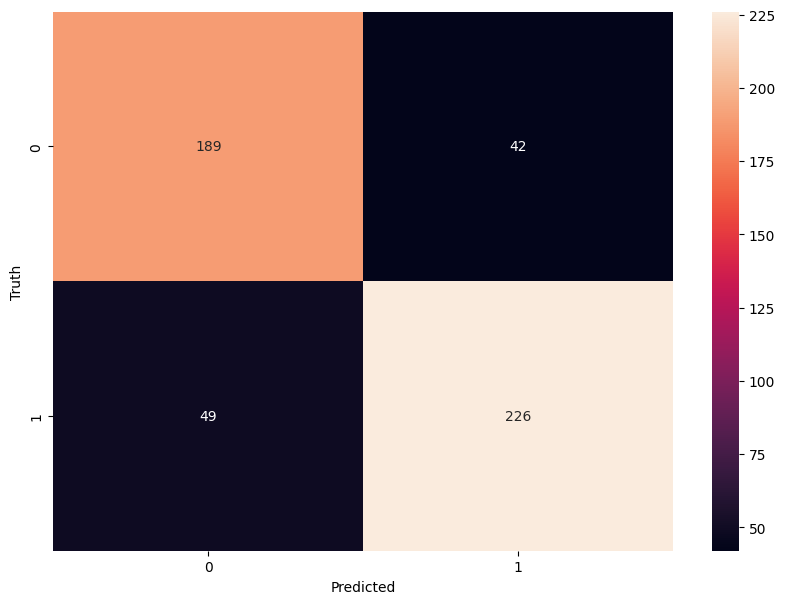

In [ ]:
target_resnet, predicted_resnet = model_infer(resnet, test_loader, device)

plot_confusion_matrix(target_resnet, predicted_resnet)

In [ ]:
plot_classification_report(target_resnet, predicted_resnet)


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       231
           1       0.84      0.82      0.83       275

    accuracy                           0.82       506
   macro avg       0.82      0.82      0.82       506
weighted avg       0.82      0.82      0.82       506



## ConvNext

<p align="justify">

Utilização do modelo pré-treinado da ConvNext. A rede ConvNext é uma evolução das redes convolucionais modernas, inspirada em arquiteturas de transformers, mas mantendo uma estrutura totalmente convolucional. A ConvNext adota várias melhorias arquiteturais, incluindo a utilização de camadas de Normalização de Resposta Global (GRN) e técnicas de aprendizado auto-supervisionado, como o autoencoder mascarado. Essas melhorias resultam em uma rede robusta e eficiente para tarefas de reconhecimento visual.

A ConvNext contém várias camadas convolucionais, normalizações e camadas fully connected no fim da rede, responsáveis pela classificação no nosso caso.

Criação da classe da ConvNext. Nessa classe estamos instanciando o modelo pré-treinado da ConvNext e definindo os pesos como sendo os padrões (treinados na ImageNet).

Além disso, estamos congelando a maioria dos pesos da rede para preservar o conhecimento pré-adquirido pelo treinamento e diminuir o tempo de treinamento para o novo dataset.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class ConvNext(nn.Module):
    def __init__(self, num_classes):
        super(ConvNext, self).__init__()
        self.convnext = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
        self.convnext.classifier[2] = nn.Linear(1024, num_classes)

        for param in self.convnext.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.convnext(x)

    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), dim=1)

In [ ]:
num_classes = 2
epochs = 10
learning_rate = 0.0001

convnext = ConvNext(num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnext.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:58<00:00, 6.02MB/s] 


In [ ]:
convnext_total_params, convnext_trainable_params = total_and_trainable_params(convnext)
history['ConvNext']['total_params'] = convnext_total_params
history['ConvNext']['trainable_params'] = convnext_trainable_params

print(convnext_total_params, convnext_trainable_params)

87568514 4098


 62%|██████▏   | 16/26 [00:07<00:04,  2.37it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.34it/s]


train_loss : 0.5886553946663352 , val_acc : 0.8376989389920424 , val_loss : 0.4703929481598047 


 77%|███████▋  | 20/26 [00:08<00:02,  2.15it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


train_loss : 0.46419097178947555 , val_acc : 0.8502155172413792 , val_loss : 0.3834531055046962 


 92%|█████████▏| 24/26 [00:10<00:00,  2.26it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


train_loss : 0.409530349668747 , val_acc : 0.8728033819628648 , val_loss : 0.3549352689431264 


 92%|█████████▏| 24/26 [00:10<00:00,  2.51it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


train_loss : 0.3712689996178175 , val_acc : 0.8867705570291776 , val_loss : 0.3288986763128868 


  8%|▊         | 2/26 [00:00<00:12,  1.97it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.32it/s]


train_loss : 0.3431935072667046 , val_acc : 0.9034731432360743 , val_loss : 0.3021523075608107 


 69%|██████▉   | 18/26 [00:07<00:03,  2.22it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


train_loss : 0.3190176019825325 , val_acc : 0.8973391909814323 , val_loss : 0.28157619960032976 


 96%|█████████▌| 25/26 [00:11<00:00,  2.25it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.29it/s]


train_loss : 0.3040975097657075 , val_acc : 0.9034731432360743 , val_loss : 0.2769381610246805 


 54%|█████▍    | 14/26 [00:06<00:05,  2.13it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.28it/s]


train_loss : 0.28982143774370833 , val_acc : 0.9109333554376657 , val_loss : 0.26144997488993865 


 19%|█▉        | 5/26 [00:01<00:08,  2.55it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.31it/s]


train_loss : 0.27696221623453715 , val_acc : 0.9141661140583555 , val_loss : 0.2526017931791452 


 42%|████▏     | 11/26 [00:04<00:06,  2.27it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

train_loss : 0.25847895495000595 , val_acc : 0.9206730769230769 , val_loss : 0.24458649697212073 


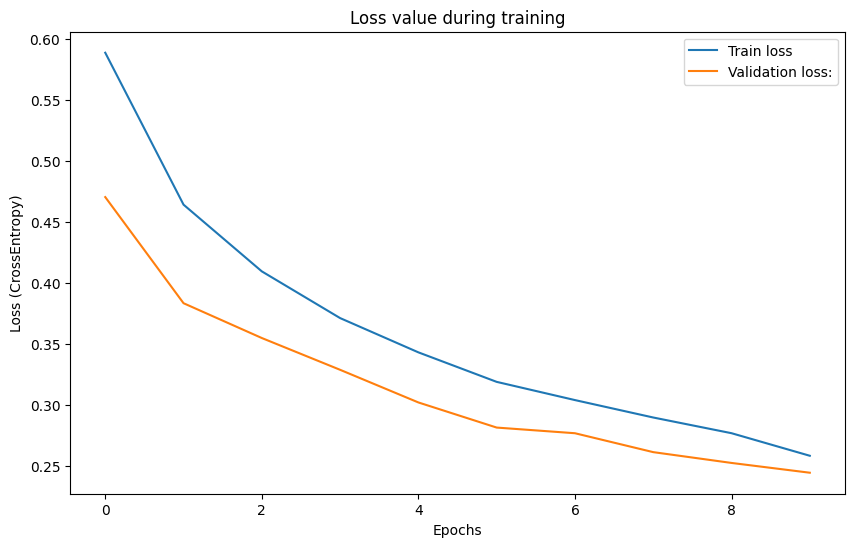

In [ ]:
time_before_train = time.time()
train(convnext, train_loader, val_loader, optimizer, loss_fn, epochs, device)
history['ConvNext']['train_time'] = time.time() - time_before_train

In [ ]:
time_before_inference = time.time()
loss_test, acc_test = test(convnext, test_loader, loss_fn, device)
history['ConvNext']['infer_time'] = time.time() - time_before_inference
history['ConvNext']['loss'] = loss_test
history['ConvNext']['acc'] = acc_test

100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

Confusion Matrix:


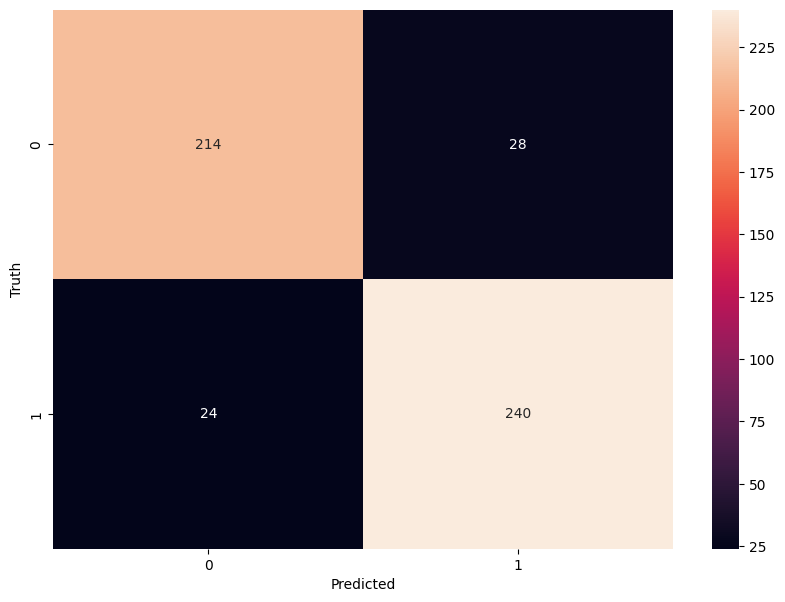

In [ ]:
target_convnext, predicted_convnext = model_infer(convnext, test_loader, device)

plot_confusion_matrix(target_convnext, predicted_convnext)

In [ ]:
plot_classification_report(target_convnext, predicted_convnext)


Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       242
           1       0.90      0.91      0.90       264

    accuracy                           0.90       506
   macro avg       0.90      0.90      0.90       506
weighted avg       0.90      0.90      0.90       506



## Ensemble

<p align="justify">
O ensemble de modelos consiste em utilizar as saídas de diferentes modelos para obter a resposta final para uma instância dos dados.

O tipo de ensemble que utilizaremos é o hard vote ensemble, que consiste em fazer uma votação entre os modelos para decidir qual a classe da imagem atual. A resposta será a classe que obteve mais votos.

O ensemble é utilizado para se obter uma maior precisão na tarefa de classificação das imagens.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def ensemble(models, test_loader, device):
    acc_ensemble = 0
    targets = []
    predicted_ensemble = []

    with torch.inference_mode():
        for (X, label) in tqdm(test_loader):
            X, label = X.to(device), label.to(device)
            models_preds = []

            for model in models:
                model.eval()
                y_pred = model(X)
                pred_label = y_pred.argmax(dim=1)
                models_preds.append(pred_label)

            ensemble_preds = []
            for idx in range(len(label)):
                votes = sum(preds[idx].item() for preds in models_preds)

                if votes > 1:
                    ensemble_preds.append(1)
                else:
                    ensemble_preds.append(0)


            label_list = label.tolist()

            predicted_ensemble.extend(ensemble_preds)
            targets.extend(label_list)

            correct_preds = sum(1 for pred, true_label in zip(ensemble_preds, label_list) if pred == true_label)
            batch_accuracy = correct_preds / len(label_list)
            acc_ensemble += batch_accuracy

        acc_ensemble /= len(test_loader)

    return acc_ensemble, targets, predicted_ensemble

In [ ]:
models = [vgg, resnet, convnext] # Falta colocar a convnext aqui também

time_before_infer_ensemble = time.time()
acc_ensemble, target_ensemble, predicted_ensemble = ensemble(models, test_loader, device)
history['Ensemble']['infer_time'] = time_before_infer_ensemble - time.time()
history['Ensemble']['acc'] = acc_ensemble

100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


In [ ]:
# target_ensemble, predicted_ensemble
print(target_ensemble)
print(predicted_ensemble)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Confusion Matrix:


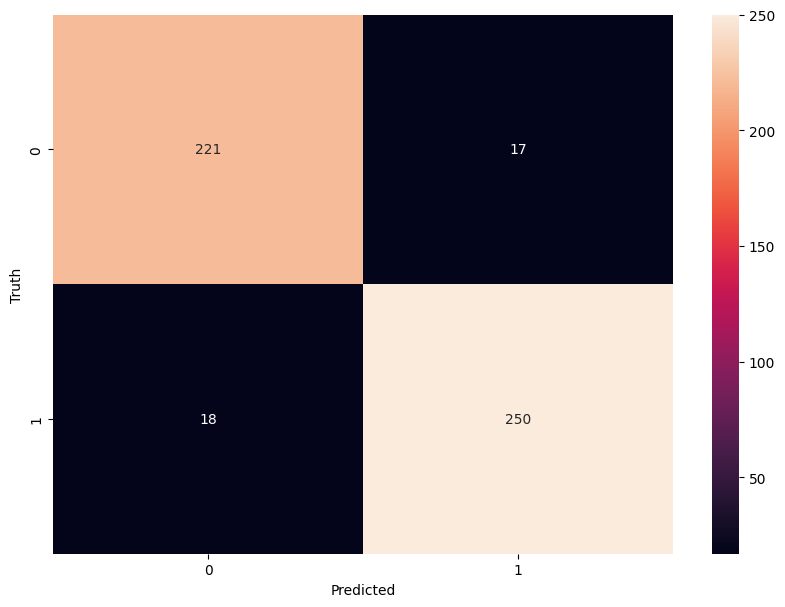

In [ ]:
plot_confusion_matrix(target_ensemble, predicted_ensemble)

In [ ]:
plot_classification_report(target_ensemble, predicted_ensemble)


Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       238
           1       0.94      0.93      0.93       268

    accuracy                           0.93       506
   macro avg       0.93      0.93      0.93       506
weighted avg       0.93      0.93      0.93       506



## Adicionando o bloco SE de atenção na ResNet


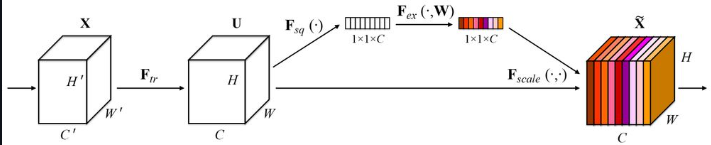

<p align="justify">

Os blocos de atenção squeeze and excitation (SE) são componentes utilizados em redes neurais convolucionais para melhorar a capacidade de focar em características importantes e suprimir as menos relevantes.

Nesse experimento, adicionamos blocos SE attention para uma rede ResNet18 pré-treinada.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

resnet_se = ResNet18(num_classes=2).to(device)

modules_to_modify = []

for name, module in resnet_se.named_modules():
    if isinstance(module, nn.Conv2d) and 'layer' in name:
        modules_to_modify.append((name, module))

for name, module in modules_to_modify:
    se_block = SEBlock(module.out_channels)
    new_module = nn.Sequential(module, se_block)
    setattr(resnet_se, name, new_module)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 10
optimizer = torch.optim.Adam(resnet_se.parameters(), lr=0.0001)

In [ ]:
resnet_se_total_params , resnet_se_trainable_params = total_and_trainable_params(resnet_se)
history['ResNetSE']['total_params'] = resnet_se_total_params
history['ResNetSE']['trainable_params'] = resnet_se_trainable_params
print(resnet_se_total_params , resnet_se_trainable_params)

11394626 218114


 35%|███▍      | 9/26 [00:01<00:02,  7.56it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.37it/s]


train_loss : 0.6503863887390876 , val_acc : 0.7183769893899205 , val_loss : 0.5812953997116822 


 62%|██████▏   | 16/26 [00:02<00:01,  6.68it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


train_loss : 0.5397369832728561 , val_acc : 0.791196949602122 , val_loss : 0.5105277701066091 


  0%|          | 0/26 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.40it/s]


train_loss : 0.48157662998846246 , val_acc : 0.8133289124668436 , val_loss : 0.4642878415492865 


 38%|███▊      | 10/26 [00:01<00:02,  5.82it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.51it/s]


train_loss : 0.44426230658296895 , val_acc : 0.8253481432360743 , val_loss : 0.43741953716828275 


 54%|█████▍    | 14/26 [00:02<00:02,  4.81it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.51it/s]


train_loss : 0.4164495136086091 , val_acc : 0.8308604111405835 , val_loss : 0.4066877456811758 


 54%|█████▍    | 14/26 [00:02<00:02,  5.66it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.51it/s]


train_loss : 0.3977166050755029 , val_acc : 0.8263013925729443 , val_loss : 0.3918606409659752 


 77%|███████▋  | 20/26 [00:03<00:01,  4.02it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.49it/s]


train_loss : 0.3800453695768303 , val_acc : 0.8272546419098142 , val_loss : 0.38010612703286684 


  8%|▊         | 2/26 [00:00<00:04,  5.48it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.50it/s]


train_loss : 0.3646453904136242 , val_acc : 0.8431283156498673 , val_loss : 0.3685684215563994 


 96%|█████████▌| 25/26 [00:04<00:00,  4.63it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.33it/s]


train_loss : 0.3535628715291568 , val_acc : 0.8468584217506632 , val_loss : 0.36782603023143917 


 31%|███       | 8/26 [00:01<00:02,  6.61it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:04<00:00,  5.51it/s]

train_loss : 0.34128796492274655 , val_acc : 0.8428796419098142 , val_loss : 0.3536063197713632 


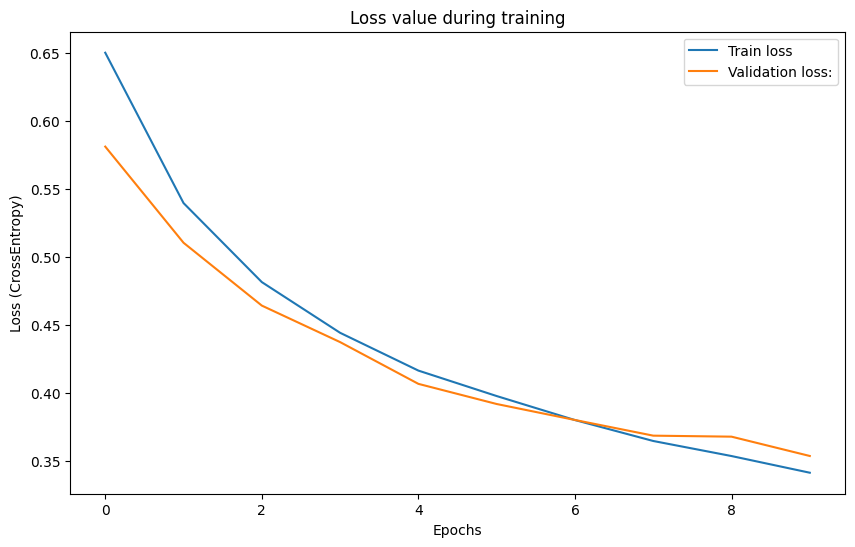

In [ ]:
time_before_train = time.time()
train(resnet_se, train_loader, val_loader, optimizer, loss_fn, epochs, device)
history['ResNetSE']['train_time'] = time.time() - time_before_train

In [ ]:
time_before_inference = time.time()
loss_test, acc_test = test(resnet_se, test_loader, loss_fn, device)
history['ResNetSE']['infer_time'] = time.time() - time_before_inference
history['ResNetSE']['loss'] = loss_test
history['ResNetSE']['acc'] = acc_test

100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

Confusion Matrix:


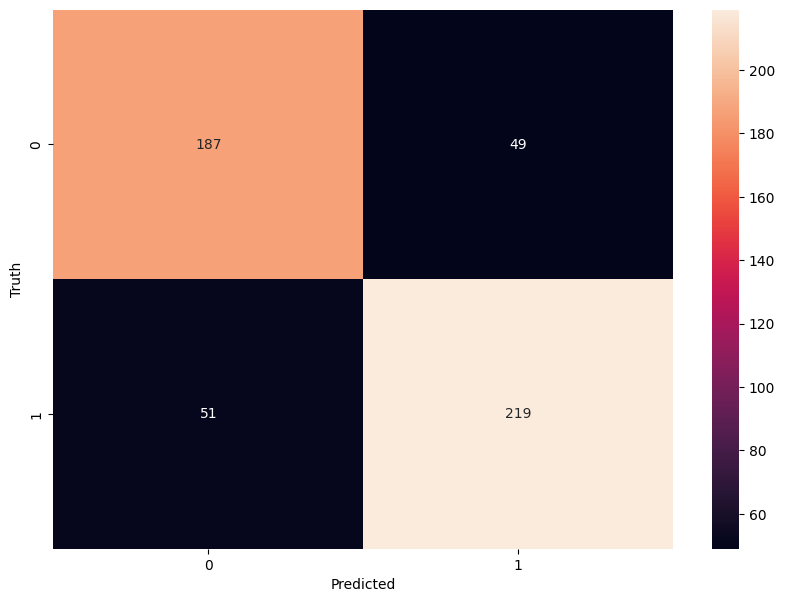

In [ ]:
target_resnet_se, predicted_resnet_se = model_infer(resnet_se, test_loader, device)

plot_confusion_matrix(target_resnet_se, predicted_resnet_se)

In [ ]:
plot_classification_report(target_resnet_se, predicted_resnet_se)


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       236
           1       0.82      0.81      0.81       270

    accuracy                           0.80       506
   macro avg       0.80      0.80      0.80       506
weighted avg       0.80      0.80      0.80       506



## Adicionando o módulo CBAM de atenção na VGG 16

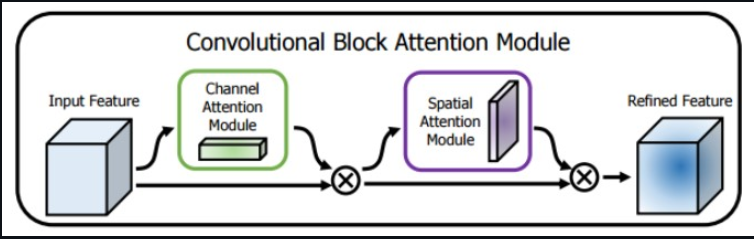

<p align="justify">
https://github.com/Peachypie98/CBAM

<p align="justify">
CBAM, um módulo de atenção simples e eficaz para redes neurais convolucionais feed-forward. É um módulo leve e geral que pode ser integrado facilmente em qualquer arquitetura de CNN e é treinável de ponta a ponta junto com as CNNs base. CBAM é usado para aumentar o poder de representação usando um mecanismo de atenção: focando em características importantes e suprimindo as desnecessárias. Para alcançar isso, aplicamos sequencialmente módulos de atenção de canal e espaciais, de modo que cada um dos ramos possa aprender 'o que' e 'onde' atender nos eixos de canal e espaciais, respectivamente.

Para aprender o que procurar na imagem, o módulo CAM (Channel Attention Module) é utilizado.

Para aprender ondep procurar na imagem e extrair informações espaciais, o módulo SAM (Spatial Attention Module) é utilizado.

In [ ]:
import torch.nn.functional as F

In [ ]:
torch.cuda.empty_cache()

<p align="justify">

Implementação dos módulos SAM, CAM e por fim o CBAM.

In [ ]:
class SAM(nn.Module):
    def __init__(self, bias=False):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        max = torch.max(x,1)[0].unsqueeze(1)
        avg = torch.mean(x,1).unsqueeze(1)
        concat = torch.cat((max,avg), dim=1)
        output = self.conv(concat)
        output = output * x
        return output

class CAM(nn.Module):
    def __init__(self, channels, r):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//self.r, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//self.r, out_features=self.channels, bias=True))

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        output = F.sigmoid(output) * x
        return output

class CBAM(nn.Module):
    def __init__(self, channels, r):
        super(CBAM, self).__init__()
        self.channels = channels
        self.r = r
        self.sam = SAM(bias=False)
        self.cam = CAM(channels=self.channels, r=self.r)

    def forward(self, x):
        output = self.cam(x)
        output = self.sam(output)
        return output + x

def conv_block(in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())

class VGG_CBAM(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.vgg = vgg16(pretrained=True)

        self.features = self.vgg.features

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.linear1 = nn.Sequential(nn.Linear(in_features=7*7*512, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear3 = nn.Linear(in_features=4096, out_features=out_channels, bias=True)

        self.cbam = CBAM(channels=512, r=4)

        for param in self.vgg.features.parameters():
          param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)  # Aplicar CBAM após as camadas convolucionais da VGG
        x = self.avg_pool(x)
        x = self.linear1(x.view(x.shape[0], -1))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [ ]:
num_classes = 2
epochs = 10
learning_rate = 0.0001

vgg_cbam = VGG_CBAM(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_cbam.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg_cbam_total_params , vgg_cbam_trainable_params = total_and_trainable_params(vgg_cbam)
history['VGG_CBAM']['total_params'] = vgg_cbam_total_params
history['VGG_CBAM']['trainable_params'] = vgg_cbam_trainable_params
print(vgg_cbam_total_params , vgg_cbam_trainable_params)

258043404 243328716


 27%|██▋       | 7/26 [00:02<00:06,  3.15it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  3.06it/s]


train_loss : 0.11443761083604381 , val_acc : 0.9735576923076923 , val_loss : 0.0786313667239693 


 62%|██████▏   | 16/26 [00:05<00:03,  3.09it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  3.07it/s]


train_loss : 0.012519622602535193 , val_acc : 0.9951923076923077 , val_loss : 0.025885373917565 


  8%|▊         | 2/26 [00:00<00:08,  2.94it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  3.08it/s]


train_loss : 0.01596123461143173 , val_acc : 0.9771634615384616 , val_loss : 0.1140062747491846 


  4%|▍         | 1/26 [00:00<00:08,  3.00it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  2.91it/s]


train_loss : 0.025558064374180463 , val_acc : 0.9794429708222812 , val_loss : 0.08601316418337145 


 19%|█▉        | 5/26 [00:01<00:07,  2.86it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  2.93it/s]


train_loss : 0.01839718906173372 , val_acc : 0.9927884615384616 , val_loss : 0.026745598939170414 


 69%|██████▉   | 18/26 [00:06<00:03,  2.61it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:09<00:00,  2.88it/s]


train_loss : 0.024991231205689725 , val_acc : 0.9987980769230769 , val_loss : 0.002774789396026993 


 31%|███       | 8/26 [00:02<00:06,  2.80it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


train_loss : 0.007418182600375032 , val_acc : 0.9987980769230769 , val_loss : 0.009240202789846181 


 88%|████████▊ | 23/26 [00:07<00:00,  3.27it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  3.05it/s]


train_loss : 0.00505529771968476 , val_acc : 0.9950679708222812 , val_loss : 0.004743835133550991 


 19%|█▉        | 5/26 [00:01<00:06,  3.01it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  3.08it/s]


train_loss : 0.0064747947912464215 , val_acc : 0.9939903846153846 , val_loss : 0.031107941809826654 


  4%|▍         | 1/26 [00:00<00:09,  2.69it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 26/26 [00:08<00:00,  2.94it/s]

train_loss : 0.020311512900592354 , val_acc : 0.9963942307692307 , val_loss : 0.016121032070174603 


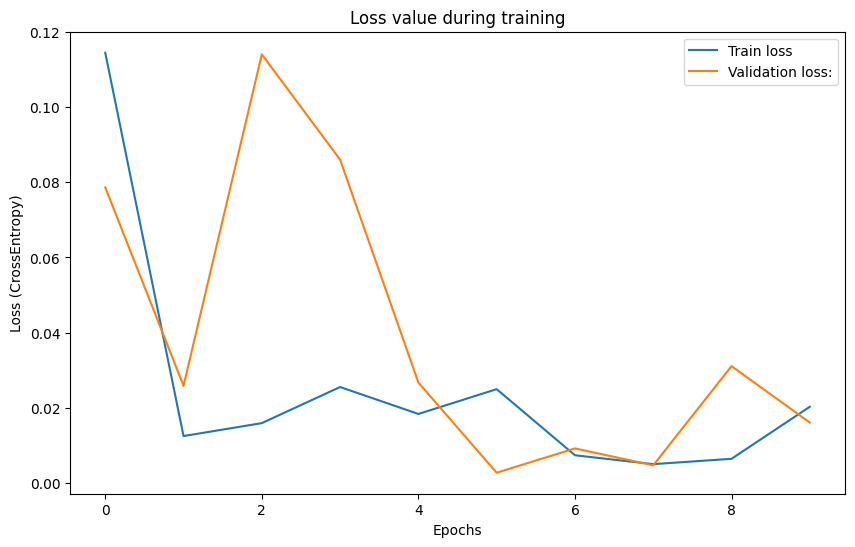

In [ ]:
time_before_train = time.time()
train(vgg_cbam, train_loader, val_loader, optimizer, loss_fn, epochs, device)
history['VGG_CBAM']['train_time'] = time.time() - time_before_train

In [ ]:
time_before_inference = time.time()
loss_test, acc_test = test(vgg_cbam, test_loader, loss_fn, device)
history['VGG_CBAM']['infer_time'] = time.time() - time_before_inference
history['VGG_CBAM']['loss'] = loss_test
history['VGG_CBAM']['acc'] = acc_test

100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


100%|██████████| 16/16 [00:05<00:00,  2.76it/s]

Confusion Matrix:


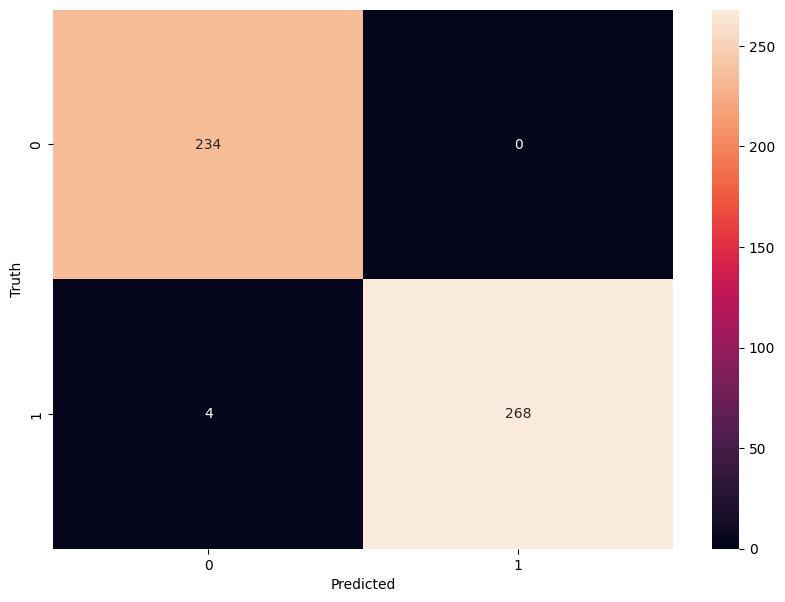

In [ ]:
target_vgg_cbam, predicted_vgg_cbam = model_infer(vgg_cbam, test_loader, device)
plot_confusion_matrix(target_vgg_cbam, predicted_vgg_cbam)

In [ ]:
plot_classification_report(target_vgg_cbam, predicted_vgg_cbam)


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       234
           1       1.00      0.99      0.99       272

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



## Comparações

<p align="justify">

Nesta seção é apresentada uma comparação entre os diferentes modelos em relação as suas acurácias, tempo de treinamento, tempo de inferência e complexidade do modelo.

In [ ]:
models = list(history.keys())

<p align="justify">
O plot abaixo compara a métrica de acurácia para diferentes modelos no dataset.

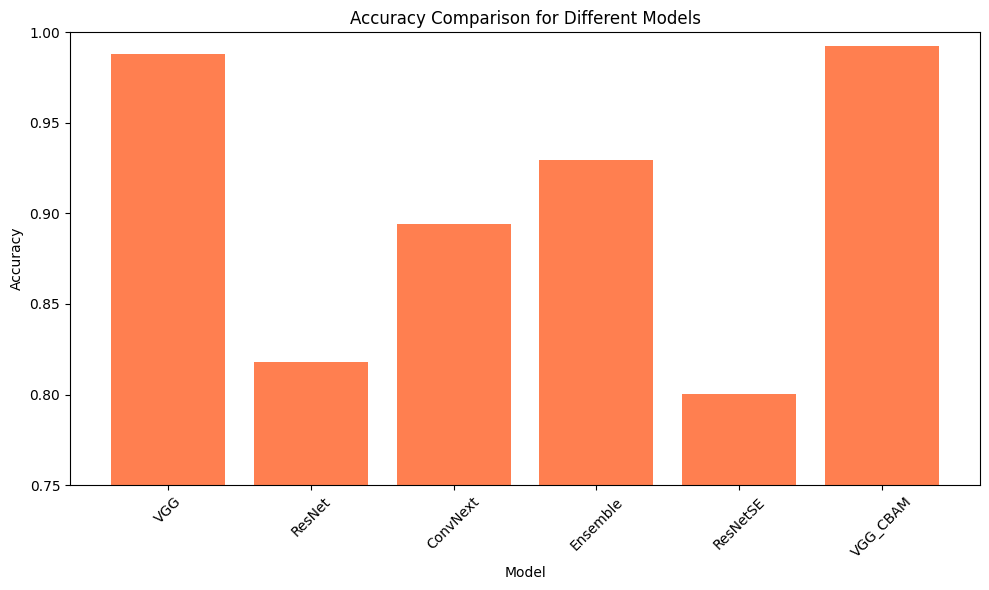

In [ ]:
models = [model for model in history if 'acc' in history[model]]

accuracies = [history[model]['acc'] for model in models]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='coral')
plt.title('Accuracy Comparison for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.75, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<p align="justify">
O plot abaixo compara o tempo de treinamento para diferentes modelos no dataset.

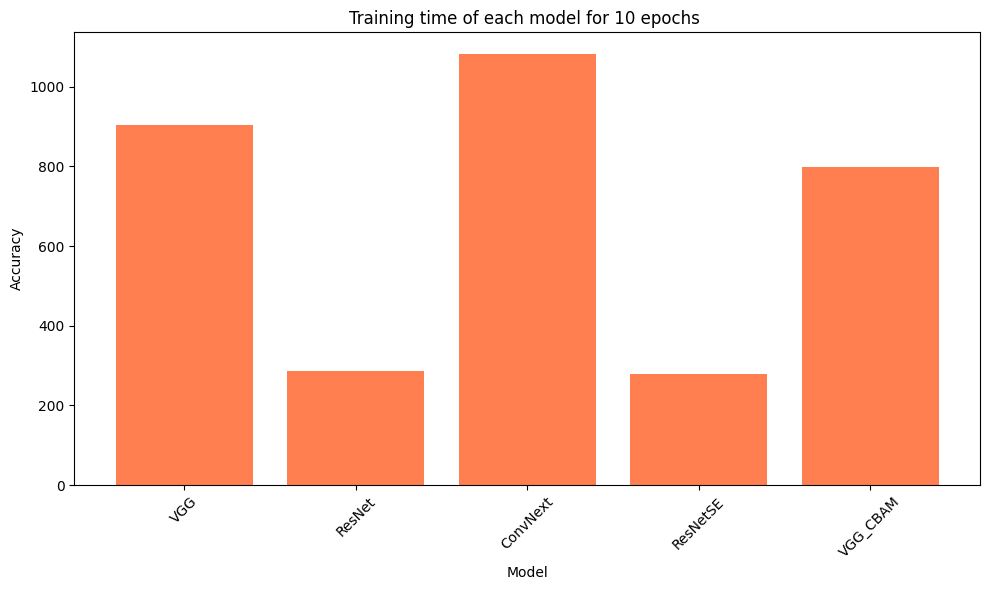

In [ ]:
models = [model for model in history if 'train_time' in history[model]]

train_time_models = [history[model]['train_time'] for model in models]

plt.figure(figsize=(10, 6))
plt.bar(models, train_time_models, color='coral')
plt.title('Training time of each model for 10 epochs ')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<p align="justify">
O plot abaixo compara o número total de parâmetros para diferentes modelos no dataset.

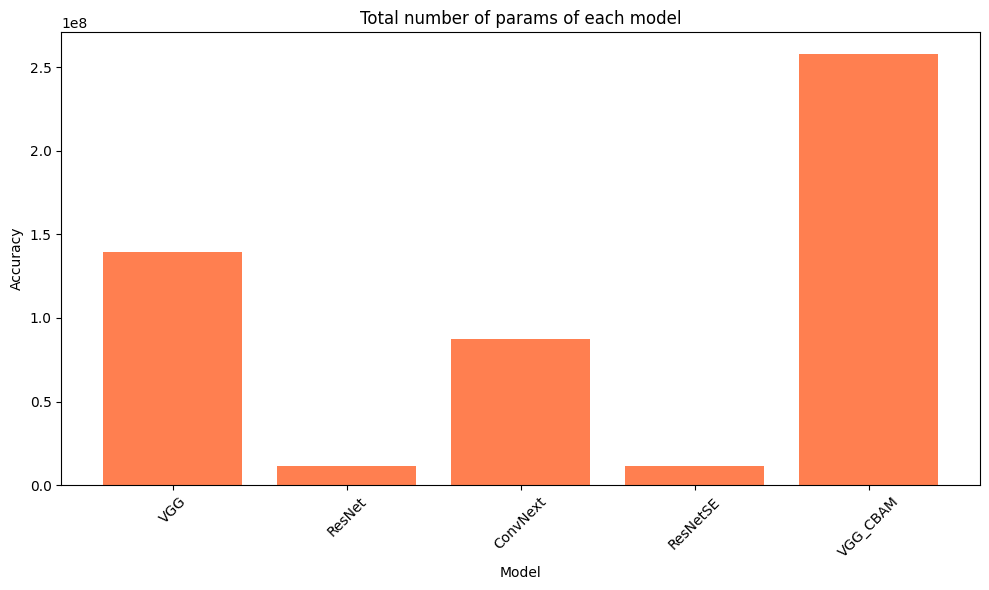

In [ ]:
models = [model for model in history if 'total_params' in history[model]]

total_params_models = [history[model]['total_params'] for model in models]

plt.figure(figsize=(10, 6))
plt.bar(models, total_params_models, color='coral')
plt.title('Total number of params of each model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Conclusão

<p align="justify">

Através das comparações apresentadas, observamos que:

**Acurácia:**

* VGG19, Ensemble e VGG19 com CBAM apresentaram as melhores acurácias, todos alcançando 99%.
* ConvNext teve uma acurácia de 90%, mostrando um desempenho sólido, mas inferior aos modelos VGG.
* ResNet18 e ResNet18 com SE Blocks apresentaram acurácias mais baixas, de 82% e 80%, respectivamente. <br>

**Tempo de Treinamento:**
* ResNet18 e ResNet18 com SE Blocks foram os modelos mais rápidos de treinar, com tempos de treinamento de apenas 5 minutos.
* VGG19 e VGG19 com CBAM tiveram tempos de treinamento de 15 e 13 minutos, respectivamente, demonstrando eficiência moderada.
* ConvNext foi o mais lento, com um tempo de treinamento de 18 minutos, refletindo sua maior complexidade. <br>

**Número de Parâmetros:**
* ResNet18 e ResNet18 com SE Blocks tiveram o menor número de parâmetros, 11,117,538 e 11,394,626, respectivamente, indicando uma menor complexidade.
VGG19 e ConvNext apresentaram números de parâmetros intermediários, 139,578,434 e 87,568,514, respectivamente.
* VGG19 com CBAM teve o maior número de parâmetros, 258,043,404, refletindo a adição dos módulos CBAM e aumentando significativamente a complexidade do modelo. <br>


Esses resultados indicam que a escolha do modelo depende do equilíbrio desejado entre acurácia, tempo de treinamento e complexidade do modelo. Modelos como VGG19, Ensemble e VGG19 com CBAM oferecem alta acurácia, mas com tempos de treinamento e número de parâmetros mais elevados. ResNet18 e ResNet18 com SE Blocks são mais rápidos de treinar e têm menos parâmetros, mas com acurácia inferior. O ConvNext apresenta uma acurácia intermediária e é o mais complexo em termos de tempo de treinamento e número de parâmetros.

A escolha do modelo ideal dependerá das prioridades específicas da aplicação, seja a precisão máxima, eficiência de treinamento ou simplicidade do modelo. Em aplicações onde a precisão é crítica e os recursos computacionais são abundantes, modelos mais complexos como VGG19 com CBAM ou um ensemble podem ser preferidos. Para aplicações que exigem rapidez no treinamento e menores recursos computacionais, ResNet18 e suas variações podem ser mais adequadas.